# Mapping Casper by Bulk Segregant Analysis

The below notebook includes all scripts used to map the *capser* mutant to *Hps5*.
Requires matplotlib, numpy, and scipy

In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
from scipy import stats
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rc('font', family='sans-serif')
matplotlib.rc('font', serif='Arial')
matplotlib.rc('text', usetex='false')
matplotlib.rc('pdf', fonttype=42)


In [2]:
## let's instead count all non-fixed variants in the data

##a wrapper class to store a parsed line from a VCF file
class Variant:
    chrome = ''
    pos = 0
    ##ref is in the 0 position, alts further
    nuc_seqs = []
    ##list of list of genotypes
    gts = []
    ##list of all GT quality scores
    quals = []
    ##reads supporting each allele
    read_depth = []

##takes a line from a VCF files and parses it
def parse_vcf_list(vcf_list):
    ##store the values in the Variant object
    cur_variant = Variant()
    cur_variant.chrome = vcf_list[0]
    cur_variant.pos = int(vcf_list[1])

    ##set the sequences for ref and alt, allowing for > 1 alt allele
    cur_ref= [vcf_list[3]]
    cur_alts = vcf_list[4].split(',')
    cur_seqs =cur_ref + cur_alts
    cur_variant.nuc_seqs = cur_seqs

    ##process the raw genotypes
    raw_gts = vcf_list[9:]
    cur_gts =  map(lambda x: x.split(':')[0].split('/'),raw_gts)
    #cur_gts =  map(lambda x: map(lambda y: int(y),x),cur_gts)
    cur_variant.gts = cur_gts
    cur_quals = []
    cur_rd_list = []
    for cur_raw_gt in raw_gts:
        cur_qual = 0
        cur_rd = []
        split = cur_raw_gt.split(':')
        if len(split) > 3:
            if split[3] == '.':
                cur_qual=0
                
            else:
                cur_qual = int(split[3])
                cur_rd = map(lambda x:int(x),split[1].split(','))
        cur_quals.append(cur_qual)
        cur_rd_list.append(cur_rd)
    #cur_quals = int(map(lambda x: x.split(':')[3],raw_gts))
    cur_variant.quals=cur_quals
    cur_variant.read_depth = cur_rd_list
    return cur_variant

##opens and parses a VCF file line by line
##yields a Variant object for each line
def VCF_parser(vcf_file):
    


    f = open(vcf_file,'r')
    
    for line in f:
        ##chomp dat header
        if line.startswith('#'):
            continue
            
        line = line.strip()
        split = line.split('\t')
        
        cur_variant = parse_vcf_list(split)
        
        
        yield cur_variant
        

##counts non-fixed variants
def count_unfixed_variants(invcf,MIN_GT=0):     
    
    unique_vars = 0

    
    for cur_variant in VCF_parser(invcf):
        ##keep track of variants we have seen, if > 1, then the variant isn't fixed
        seen_vars = set()
        for i,genotype in enumerate(cur_variant.gts):
            for allele in genotype:
                cur_qual = cur_variant.quals[i]
                ##only continue if the variant is of sufficient quality
                if cur_qual < MIN_GT:
                    continue
                
                ##if the allele isn't a digit, it is missing, ignore it
                if not allele.isdigit():
                    continue
                
                
                seen_vars.add(allele)
        
        ##count all unfixed alleles (>1 allele can be unfixed)
        ##can't be less than 0
        cur_new_vars = max(len(seen_vars) - 1,0)
        if cur_new_vars >= 1:
            pass
            #print cur_variant.nuc_seqs
            #print cur_variant.gts
            #print cur_variant.chrome,cur_variant.pos
        unique_vars += cur_new_vars
    
    return unique_vars
        

def filter_vcf_bed(invcf,outbed):
    
    w = open(outbed,'w')
    
    
    for cur_variant in VCF_parser(invcf):
        
        cur_chrome = cur_variant.chrome
        cur_start = cur_variant.pos -1
        cur_stop = cur_variant.pos
        
        boc_gt = cur_variant.gts[1] 
        
        ##ignore missing and ref positions
        if boc_gt[0] == '.':
            continue
        if boc_gt[0] == '0' and boc_gt[1] == '0':
            continue
        
        bedline = cur_chrome + '\t' + str(cur_start) + '\t' + str(cur_stop)
        w.write(bedline + '\n')
            
    w.flush()
    w.close()
    
#filter_vcf_bed('/home/james/Dropbox/Miller/data/casper/casper_variants_100616.vcf','/home/james/Dropbox/Miller/data/casper/casper_variants_100616_BoC.bed')    

(0, 1.2)

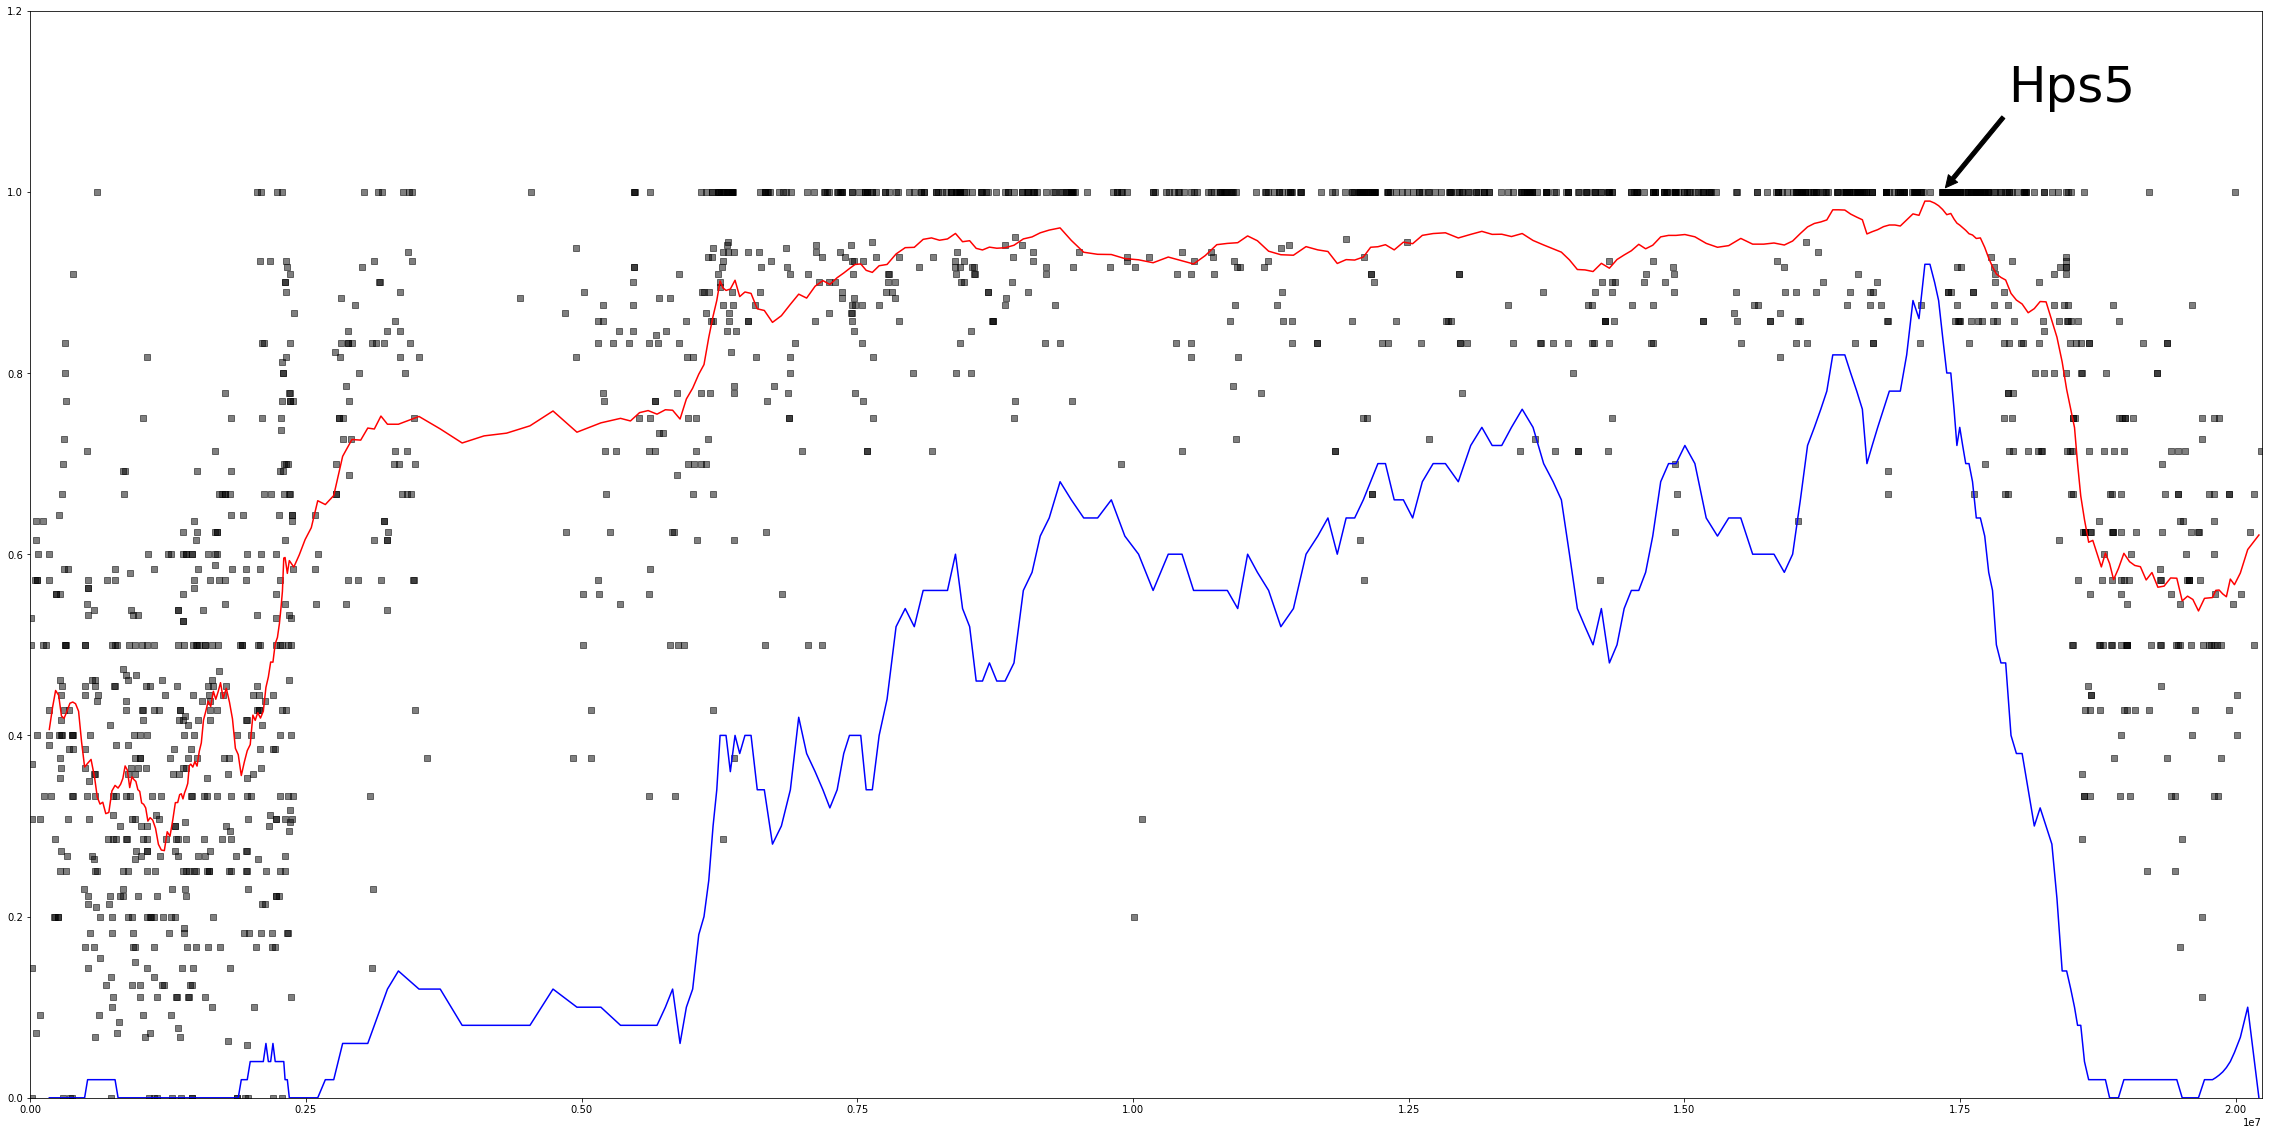

In [7]:
def count_nonparental(invcf,outbga):


    w = open(outbga,'w')
    w.write("track type=bedGraph name=bsa_parental_allele\n")
    
    bga_baseline = '{0}\t{1}\t{2}\t{3}\n'
    for cur_variant in VCF_parser(invcf):

        if cur_variant.chrome != 'chrXIX':
            continue
        
        casper_gt = cur_variant.gts[0]
        ##only count positions where casper is homozygous
        if casper_gt[0] != casper_gt[1]:
            continue
        boc_gt = cur_variant.gts[1] 
        bsa_gt = cur_variant.gts[2]
        bsa_rd = cur_variant.read_depth[2]
        
        ##remove missing
        if casper_gt[0] == '.' or boc_gt[0] == '.' or bsa_gt[0] == '.':
            continue
            
        
        
        casper_allele = int(casper_gt[0])
        #print bsa_rd,casper_allele
        bsa_cas_rd = bsa_rd[casper_allele]
        
        bsa_total_rd = sum(bsa_rd)
        if bsa_total_rd <= 0:
            continue
        proportion_cas = float(bsa_cas_rd)/bsa_total_rd
        
        bga_line = bga_baseline.format(cur_variant.chrome,cur_variant.pos-1,cur_variant.pos,proportion_cas)
        w.write(bga_line)
    
    w.flush()
    w.close()

##Walks through the VCF file
##Keeps track of het variants within a window as well as proportion of each variant that matches casper
def plot_nonparental(invcf,COV_CUT=5,WINDOW=10,QUAL_CUT=40,STEP=10):

    positions = []
    proportions = []
    cpr_count = []
    total_count = []
    hets = []

    
    for cur_variant in VCF_parser(invcf):

        if cur_variant.chrome != 'chrXIX':
            continue
        
        casper_gt = cur_variant.gts[0]
        ##only count positions where casper is homozygous
        if casper_gt[0] != casper_gt[1] or casper_gt[0] == '0':
            continue
        boc_gt = cur_variant.gts[1] 
        bsa_gt = cur_variant.gts[2]
        bsa_rd = cur_variant.read_depth[2]
        
        ##remove missing
        if casper_gt[0] == '.' or boc_gt[0] == '.' or bsa_gt[0] == '.':
            continue
            
        casper_qual = cur_variant.quals[0]
        if casper_qual < QUAL_CUT:
            continue
        
        ##only consider alleles not in BoC
        if boc_gt[0] == casper_gt[0] or boc_gt[1] == casper_gt[0]:
            continue
        
        casper_allele = int(casper_gt[0])
        #print bsa_rd,casper_allele
        bsa_cas_rd = bsa_rd[casper_allele]
        
        bsa_total_rd = sum(bsa_rd)
        if bsa_total_rd <= COV_CUT:
            continue
        proportion_cas = float(bsa_cas_rd)/bsa_total_rd
        if proportion_cas < 1:
            hets.append(1)
        else:
            hets.append(0)
        
        positions.append(cur_variant.pos)
        proportions.append(proportion_cas)
        cpr_count.append(bsa_cas_rd)
        total_count.append(bsa_total_rd)
        
    
    window_positions = []
    window_proportions = []
    window_hets = []
    window_proportions_high = []
    window_proportions_low = []

    for i in range(len(positions)/STEP):
        cur_positions = positions[i*STEP:i*STEP+WINDOW]
        cur_cpr_counts = cpr_count[i*STEP:i*STEP+WINDOW]
        cur_het_counts = hets[i*STEP:i*STEP+WINDOW]
        cur_total_counts = total_count[i*STEP:i*STEP+WINDOW]
        
        cur_proportions = np.array(map(lambda x: float(x),cur_cpr_counts))/np.array(cur_total_counts)
        cur_proportion_std = cur_proportions.std()
        mean_position = sum(cur_positions)/len(cur_positions)
        med_proportion = np.median(cur_proportions)
        mean_proportion = sum(cur_proportions)/len(cur_proportions)
        high = mean_proportion + cur_proportion_std
        low = mean_proportion - cur_proportion_std
        window_proportions_high.append(high)
        window_proportions_low.append(low)
        #mean_proportion = float(sum(cur_cpr_counts))/sum(cur_total_counts)
        mean_het = 1-float(sum(cur_het_counts))/len(cur_total_counts)
        
        window_positions.append(mean_position)
        window_proportions.append(mean_proportion)
        window_hets.append(mean_het)
        
        
    fig,ax = plt.subplots(figsize=(40,20))
    ax.scatter(positions,proportions,marker=',',color='k',alpha=.5)
    ax.plot(window_positions,window_proportions,color='r')
    #ax.plot(window_positions,window_proportions_low,color='r',ls='--')
    #ax.plot(window_positions,window_proportions_high,color='r',ls='--')
    ax.plot(window_positions,window_hets,color='b')


    return ax
    
def plot_hets(invcf,COV_CUT=5,WINDOW=50,QUAL_CUT=30):

    positions = []
    ##scored 1 for het, 0 for homozygous casper
    hets = []



    
    for cur_variant in VCF_parser(invcf):

        if cur_variant.chrome != 'chrXIX':
            continue
        
        casper_gt = cur_variant.gts[0]
        ##only count positions where casper is homozygous
        if casper_gt[0] != casper_gt[1] or casper_gt[0] == '0':
            continue
        boc_gt = cur_variant.gts[1] 
        bsa_gt = cur_variant.gts[2]
        bsa_rd = cur_variant.read_depth[2]
        
        ##remove missing
        if casper_gt[0] == '.' or boc_gt[0] == '.' or bsa_gt[0] == '.':
            continue
            
        ##only consider alleles not in BoC
        if boc_gt[0] == casper_gt[0] or boc_gt[1] == casper_gt[0]:
            continue
        casper_qual = cur_variant.quals[0]
        if casper_qual < QUAL_CUT:
            continue
        
        casper_allele = int(casper_gt[0])
        #print bsa_rd,casper_allele
        bsa_cas_rd = bsa_rd[casper_allele]
        
        bsa_total_rd = sum(bsa_rd)
        if bsa_total_rd <= COV_CUT:
            continue
        proportion_cas = float(bsa_cas_rd)/bsa_total_rd
        if proportion_cas < 1:
            hets.append(1)
        else:
            hets.append(0)
        
        positions.append(cur_variant.pos)
        
    
    window_positions = []
    window_proportions = []
    
    for i in range(0,len(positions),WINDOW):
        cur_positions = positions[i:i+WINDOW]
        cur_het_counts = hets[i:i+WINDOW]
        cur_total_counts = len(hets[i:i+WINDOW])
        mean_position = sum(cur_positions)/len(cur_positions)
        #med_proportion = np.median(cur_proportions)
        #mean_proportion = sum(cur_proportions)/len(cur_proportions)
        mean_proportion = float(sum(cur_het_counts))/cur_total_counts
        window_positions.append(mean_position)
        window_proportions.append(mean_proportion)
    
    fig,ax = plt.subplots(figsize=(40,20))
    ax.plot(window_positions,window_proportions,color='r')

    ax.plot([6823993,6823994,7369252,7369253],[0,1,1,0],color='g')
    
    #chrXIX:9,963,362-15,217,672   

        


ax = plot_nonparental('casper_variants_chr19.vcf',WINDOW=50,STEP=5)
ax.annotate('Hps5',xy=(17337792,1),xytext=(17937792,1.1),arrowprops=dict(facecolor='black', shrink=0.05),fontsize=50)
ax.set_xlim([0,20240660])
ax.set_ylim([0,1.2])





[   0.    0.    0.    0.    7.   16.    0.    0.    0.    3.   58.   45.
  105.]
MannwhitneyuResult(statistic=86.5, pvalue=0.029909964062237438)


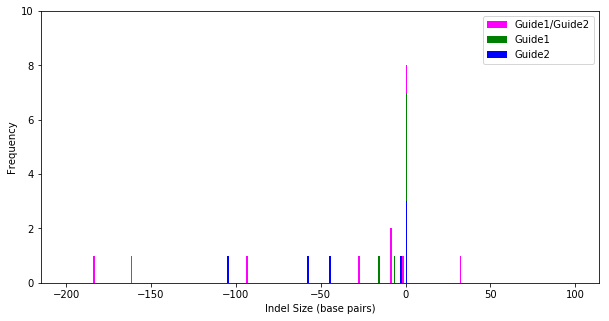

In [6]:
#The below plots a histogram of deletion sizes from differing Hps5 guide RNAs
g1 = [0,0,0,0,-7,-16]
g2 = [0,0,0,-3,-58,-45,-105]
dual_g1g2 = [-2,-9,-184,-94,0,-162,-28,-9,32]
#guide 1 only in 9/10
dual_g1 = [6,12,0,0,0,12,-1]
#guide 2 only in 9/10
dual_g2 = [-8,-21,-94,0,-28,-21,33]

bins = np.arange(-200,100)

g1_indel_array = np.fabs(np.array(g1))
g2_indel_array = np.fabs(np.array(g2))
all_single = np.fabs(np.array(g1 + g2))
dual_g1g2_indel_array = np.fabs(np.array(dual_g1g2))
print all_single

##dual guides have larger deletions than singles, pvalue=0.029909964062237438
print stats.mannwhitneyu(dual_g1g2_indel_array,all_single,alternative='greater')


plt.figure(figsize=(10,5))
plt.hist(dual_g1g2+g1+g2,bins=bins,color='magenta',label='Guide1/Guide2')
plt.hist(g1+g2,bins=bins,color='green',label='Guide1')
plt.hist(g2,bins=bins,color='blue',label='Guide2')
plt.ylim([0,10])
plt.xlabel('Indel Size (base pairs)')
plt.ylabel('Frequency')
plt.legend()
